In [4]:
from matplotlib import pyplot as plt

from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.utils import np_utils
import numpy as np

from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
from tensorflow.examples.tutorials.mnist import input_data

In [6]:
X_train = input_data.read_data_sets("mnist").train.images
X_train = X_train.reshape(-1, 28, 28, 1).astype(np.float32)

Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


(28, 28, 1)


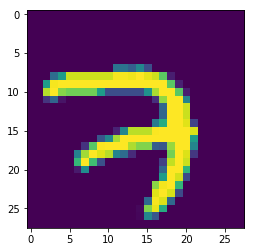

In [7]:
print(X_train[0].shape)
plt.imshow(X_train[0].reshape(28, 28))

In [27]:
class GAN(object):
    def __init__(self, img_width, img_height, img_channels, DM_optimizer = RMSprop(lr = 0.0002, decay = 6e-8),\
                 AM_optimizer = RMSprop(lr = 0.0001, decay = 3e-8), print_summary = False):
        
        self.input_shape = (img_width, img_height, img_channels)
        self.input_noice_dim = 100
        
        if print_summary:
            print("Generator:")
        self.Gen = self.__generator(print_summary)
        
        if print_summary:
            print("\nDiscriminator:")
        self.Dis = self.__discriminator(print_summary)
        
        if print_summary:
            print("\nDM:")
        self.DM = self.__dm(DM_optimizer, print_summary)
        
        if print_summary:
            print("\nAM:")
        self.AM = self.__am(AM_optimizer, print_summary)
        
    def __generator(self, print_summary = False):
        g = Sequential()
        dropout = 0.5
        depth = 256
        dim = int(self.input_shape[0] / 4)
        
        g.add(Dense(dim * dim * depth, input_dim = self.input_noice_dim))
        g.add(BatchNormalization(momentum = 0.9))
        g.add(Activation('relu'))
        g.add(Reshape((dim, dim, depth)))
        g.add(Dropout(dropout))
        
        g.add(UpSampling2D())
        g.add(Conv2DTranspose(int(depth / 2), 5, padding = 'same'))
        g.add(BatchNormalization(momentum = 0.9))
        g.add(Activation('relu'))
        
        g.add(UpSampling2D())
        g.add(Conv2DTranspose(int(depth / 4), 5, padding = 'same'))
        g.add(BatchNormalization(momentum = 0.9))
        g.add(Activation('relu'))
        
        g.add(Conv2DTranspose(int(depth / 8), 5, padding = 'same'))
        g.add(BatchNormalization(momentum = 0.9))
        g.add(Activation('relu'))
        
        g.add(Conv2DTranspose(self.input_shape[2], 5, padding = 'same'))
        g.add(Activation('sigmoid'))
        
        if print_summary:
            g.summary()

        return g
    
    def __discriminator(self, print_summary = False):
        d = Sequential()
        dropout = 0.5
        depth = 64
        
        d.add(Conv2D(depth * 1, 5, strides = 2, input_shape = self.input_shape, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Conv2D(depth * 2, 5, strides = 2, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Conv2D(depth * 4, 5, strides = 2, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Conv2D(depth * 8, 5, strides = 1, padding = 'same'))
        d.add(LeakyReLU(alpha = 0.2))
        d.add(Dropout(dropout))
        
        d.add(Flatten())
        d.add(Dense(1))
        d.add(Activation('sigmoid'))
        
        if print_summary:
            d.summary()
            
        return d
    
    def __dm(self, optimizer, print_summary = False):
        self.Dis.trainable = True
        dm = Sequential()
        dm.add(self.Dis)
        
        if print_summary:
            dm.summary()
        
        dm.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
        
        return dm
    
    def __am(self, optimizer, print_summary = False):
        #Freezing Discriminator weights during the generator adversarial training
        self.Dis.trainable = False
        am = Sequential()
        am.add(self.Gen)
        am.add(self.Dis)
        
        if print_summary:
            am.summary()
        
        am.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
        
        return am
    
    def train(self, steps, batch_size, real_imgs, info_rate = 10):
        for i in range(steps):
            r = real_imgs[np.random.randint(0, real_imgs.shape[0], size = batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size = [batch_size, self.input_noice_dim])
            f = self.Gen.predict(noise)
            x = np.concatenate((r, f))
            y = np.ones([2 * batch_size, 1])
            y[batch_size:, :] = 0
            dm_loss = self.DM.train_on_batch(x, y)
            
            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, self.input_noice_dim])
            am_loss = self.AM.train_on_batch(noise, y)
            
            if i % info_rate == 0:
                print("Step:", i, "DM loss:", dm_loss, "AM loss:", am_loss)

In [31]:
cnn = GAN(28, 28, 1, print_summary = True)

Generator:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_9 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_13 (Activation)   (None, 12544)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 256)         0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 128)       819328    

In [ ]:
print(X_train.shape)
cnn.train(5000, 256, X_train)

(55000, 28, 28, 1)
Step: 0 DM loss: [0.5978104, 0.671875] AM loss: [0.9709818, 0.25390625]
Step: 10 DM loss: [0.6103101, 0.6542969] AM loss: [0.96724033, 0.21484375]
Step: 20 DM loss: [0.6025984, 0.671875] AM loss: [0.9396583, 0.2265625]
Step: 30 DM loss: [0.62693524, 0.65625] AM loss: [0.93578476, 0.2578125]
Step: 40 DM loss: [0.61203074, 0.6660156] AM loss: [0.98934627, 0.21484375]
Step: 50 DM loss: [0.624954, 0.65625] AM loss: [0.917559, 0.26953125]
Step: 60 DM loss: [0.6082529, 0.671875] AM loss: [0.87570953, 0.328125]
Step: 70 DM loss: [0.61747056, 0.6542969] AM loss: [0.8610754, 0.30078125]
Step: 80 DM loss: [0.59423196, 0.6738281] AM loss: [0.86998314, 0.30859375]
Step: 90 DM loss: [0.6225321, 0.64453125] AM loss: [1.0216804, 0.203125]
Step: 100 DM loss: [0.62939334, 0.64453125] AM loss: [0.9024863, 0.2890625]
Step: 110 DM loss: [0.61517143, 0.6621094] AM loss: [0.9590739, 0.25]
Step: 120 DM loss: [0.6424811, 0.6386719] AM loss: [1.111222, 0.16015625]
Step: 130 DM loss: [0.63581

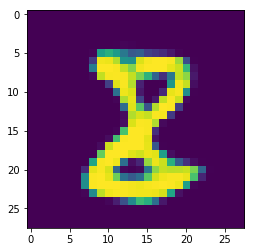

In [135]:
noise = np.random.uniform(-1.0, 1.0, size = [1, cnn.input_noice_dim])
i = cnn.Gen.predict(noise)
plt.imshow(i.reshape(28,28))